In [1]:
%pylab inline
#mudança teste 

Populating the interactive namespace from numpy and matplotlib




# Example: Extracellular current stimulation #
This is an example of **``LFPy``** running in an **``IPython notebook``**. To run through this example code and produce output, press **``<shift-Enter>``** in each code block below.

First step is to **import ``LFPy``** and other packages for analysis and plotting:

In [2]:
import numpy as np
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron

## Fetch Hay et al. 2011 model files

In [3]:
if not os.path.isfile('L5bPCmodelsEH/morphologies/cell1.asc'):
    #get the model files:
    u = urlopen('http://senselab.med.yale.edu/ModelDB/eavBinDown.asp?o=139653&a=23&mime=application/zip',
                context=ssl._create_unverified_context())
    localFile = open('L5bPCmodelsEH.zip', 'wb')
    localFile.write(u.read())
    localFile.close()
    #unzip:
    myzip = zipfile.ZipFile('L5bPCmodelsEH.zip', 'r')
    myzip.extractall('.')
    myzip.close()

#compile mod files every time, because of incompatibility with Mainen96 files:
if "win32" in sys.platform:
    pth = "L5bPCmodelsEH/mod/"
    warn("no autompile of NMODL (.mod) files on Windows.\n" 
         + "Run mknrndll from NEURON bash in the folder L5bPCmodelsEH/mod and rerun example script")
    if not pth in neuron.nrn_dll_loaded:
        neuron.h.nrn_load_dll(pth+"nrnmech.dll")
    neuron.nrn_dll_loaded.append(pth)
else:
    os.system('''
              cd L5bPCmodelsEH/mod/
              nrnivmodl
              ''')
    neuron.load_mechanisms('L5bPCmodelsEH/mod/')

In [4]:
# define cell parameters used as input to cell-class
cellParameters = {
    'morphology'    : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'templatefile'  : ['L5bPCmodelsEH/models/L5PCbiophys3.hoc',
                       'L5bPCmodelsEH/models/L5PCtemplate.hoc'],
    'templatename'  : 'L5PCtemplate',
    'templateargs'  : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'passive' : False,
    'nsegs_method' : None,
    'dt' : 2**-6,
    'tstart' : -159,
    'tstop' : 10,
    'v_init' : -60,
    'celsius': 34,
    'pt3d' : True,
    'extracellular': True,
}

# Defining plotting function

In [5]:
LFPy.cell.neuron.h("forall delete_section()")

generator_cell = LFPy.TemplateCell(**cellParameters)
generator_cell.set_rotation(x=4.729, y=-3.166)
for sec in generator_cell.allseclist:
    for seg in sec:
        seg.e_pas = -59.5


# Let's put electrodes at each segment of the second cell
electrodeParameters = {
    'sigma' : 0.3,                  # extracellular conductivity
    'x' : generator_cell.xmid+100,      # x,y,z-coordinates of contacts
    'y' : generator_cell.ymid,
    'z' : generator_cell.zmid,
    'method' : 'soma_as_point',  #sphere source soma segment
    'N' : np.array([[0, 1, 0]]*generator_cell.xmid.size), #surface normals
    'r' : 2.5,              # contact site radius
    'n' : 20,               # datapoints for averaging
}

electrode = LFPy.RecExtElectrode(**electrodeParameters)
generator_cell.simulate(electrode = electrode)

In [6]:
# perform NEURON simulation, results saved as attributes in the cell instance
receptor_cell = LFPy.TemplateCell(**cellParameters)
receptor_cell.set_rotation(x=4.729, y=-3.166)
receptor_cell.xmid += 100

t = np.arange(electrode.LFP.shape[1]) * receptor_cell.dt
receptor_cell.insert_v_ext(electrode.LFP, t)
receptor_cell.simulate(rec_vmem=True)

Overwriting custom temperature of 34.00. New temperature is 34.00


Text(0.5, 0, 'Time')

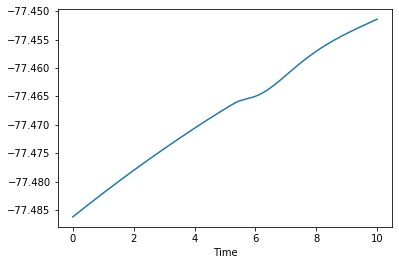

In [7]:


plt.plot(t,receptor_cell.vmem[140])
plt.xlabel("Time")

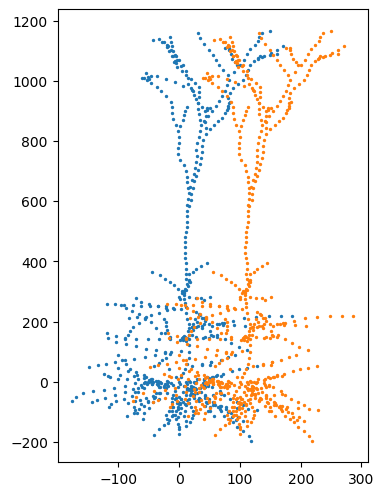

In [8]:
plt.figure(dpi=100,
          figsize=(4,6))

plt.scatter(generator_cell.xmid, generator_cell.zmid,s=2)
plt.scatter(receptor_cell.xmid, receptor_cell.zmid,s=2)

In [9]:
positions = np.array(list(zip(generator_cell.xmid, generator_cell.zmid)))

target = np.array([200,200])
target_index = ((positions - target)**2).sum(axis=1).argmin()

target_pos = positions[target_index]

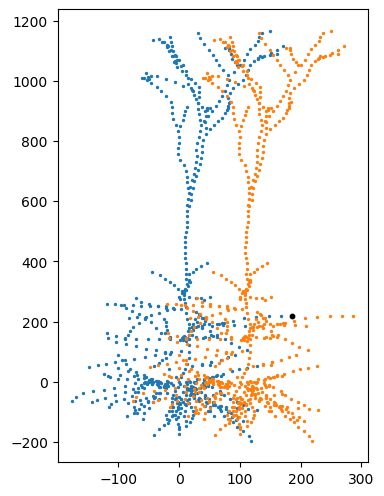

In [10]:
plt.figure(dpi=100,
          figsize=(4,6))

plt.scatter(generator_cell.xmid, generator_cell.zmid,s=2)
plt.scatter(receptor_cell.xmid, receptor_cell.zmid,s=2)

plt.scatter(target_pos[0],target_pos[1],s=10,color='k')